In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import cv2
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
import seaborn as sns
import cv2
import numpy as np
import tensorflow as tf
import time
import PIL
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/FYP/train_cepha.csv")
train_dir = "/content/drive/MyDrive/FYP/Train/images"
val_dir = "/content/drive/MyDrive/FYP/Val/images"
image_dir="/content/drive/MyDrive/FYP/cepha400"


In [ ]:
landmark_names = [str(i) for i in range(1,20)]

In [ ]:
def plot_image_with_landmarks(image_path, landmarks, image_dir):
    img = cv2.imread(os.path.join(image_dir, image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    for i in range(1, 20):
        plt.scatter(landmarks[f'{i}_x'], landmarks[f'{i}_y'], c='blue', s=30, label=f'Landmark {i}' if i == 1 else "")

    plt.title(f"Image: {image_path}")
    plt.show()
landmarks = train_data.iloc[0].drop('image_path')
landmarks = landmarks.astype(float)

In [ ]:
train_cepha_df = pd.read_csv("/content/drive/MyDrive/FYP/train_cepha.csv")
test1_df = pd.read_csv("/content/drive/MyDrive/FYP/test1.csv")
test2_df = pd.read_csv("/content/drive/MyDrive/FYP/test2.csv")

# Combine the DataFrames
combined_df = pd.concat([train_cepha_df, test1_df, test2_df], ignore_index=True)

# Save the combined DataFrame
combined_df.to_csv("combined_cepha.csv", index=False)

print("combined_cepha.csv created.")

combined_cepha.csv created.


In [ ]:
train_df = pd.DataFrame()
val_df = pd.DataFrame()

# Iterate through the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    image_path = row['image_path']
    image_number = int(os.path.splitext(os.path.basename(image_path))[0].replace("image", "")) #extract image number.

    # Assign rows to the correct DataFrame based on image number
    if 1 <= image_number <= 150:
        val_df = pd.concat([val_df, pd.DataFrame([row])], ignore_index=True)
    elif 151 <= image_number <= 400:
        train_df = pd.concat([train_df, pd.DataFrame([row])], ignore_index=True)

def sort_by_image_number(df):
        df['image_number'] = df['image_path'].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0].replace("image", "")))
        df = df.sort_values(by='image_number')
        df = df.drop(columns=['image_number'])
        return df

train_df = sort_by_image_number(train_df)
val_df = sort_by_image_number(val_df)
# Save the training and validation DataFrames to separate CSV files
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

print("train.csv and val.csv created.")

train.csv and val.csv created.


In [ ]:
def extract_features_resnet50(image_paths, image_dir):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)

    features = []
    for img_path in image_paths:
        full_img_path = os.path.join(image_dir, img_path)
        img = cv2.imread(full_img_path)
        if img is None:
            print(f"Warning: Image not found: {full_img_path}")
            features.append(np.zeros(2048)) # Append zeros if image not found to maintain data structure.
            continue
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)
        feature = model.predict(img)
        features.append(feature.flatten())
    return np.array(features)

def map_landmarks_to_resnet_features(csv_file, image_dir):
    """Maps landmark coordinates to ResNet50 features."""
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    landmark_coords = df.iloc[:, 1:].values  # Landmark coordinates start from the second column

    resnet_features = extract_features_resnet50(image_paths, image_dir)

    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(resnet_features, landmark_coords, test_size=0.2, random_state=42)

    # Simple linear regression model (you can replace with more complex models)
    landmark_model = tf.keras.Sequential([
        Dense(512, activation='relu', input_shape=(2048,)),
        Dense(landmark_coords.shape[1])  # Output shape matches the number of landmark coordinates
    ])

    landmark_model.compile(optimizer='adam', loss='mse')
    landmark_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    # Evaluate the model
    loss = landmark_model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")

    return landmark_model

# Example Usage:
csv_file_path = "/content/combined_cepha.csv"
image_directory = "/content/drive/MyDrive/FYP/cepha400"

landmark_prediction_model = map_landmarks_to_resnet_features(csv_file_path, image_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2130377.7500 - val_loss: 2111090.2500
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2110450.7500 - val_loss: 2069768.3750
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2064041.8750 - val_loss: 1999272.6250
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1983881.7500 - val_loss: 1895170.0000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1868832.5000 - val_loss: 1756424.3750
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1710408.7500 - val_loss: 1585810.6250
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1552461.0000 - val_loss: 1389641.0000
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1341456.3750 - val_loss: 1178002.5000
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1130571.8750 - val_loss: 962107.1250
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 911593.0000 - val_loss: 754741.8750
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
def create_yolo_labels(csv_file, image_dir, labels_dir):
    """Creates YOLO format label files from a CSV file."""
    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():
        image_path = row['image_path']
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        label_file_path = os.path.join(labels_dir, f"{image_name}.txt")

        img = cv2.imread(os.path.join(image_dir, image_path))
        if img is None:
            print(f"Warning: Image not found: {os.path.join(image_dir, image_path)}")
            continue
        height, width, _ = img.shape

        with open(label_file_path, 'w') as f:
            for i in range(1, 20):  # Assuming 19 landmarks
                x = row[f'{i}_x']
                y = row[f'{i}_y']

                x_center = x / width
                y_center = y / height
                bbox_width = 10 / width  # Adjust as needed
                bbox_height = 10 / height # Adjust as needed

                if bbox_width <= 0 or bbox_height <= 0 or x_center <= 0 or y_center <= 0 or x_center >= 1 or y_center >= 1:
                    print(f"Warning: Invalid bounding box for image {image_path}, Landmark {i}. Skipping.")
                    continue

                f.write(f"{i-1} {x_center} {y_center} {bbox_width} {bbox_height}\n")

train_csv = "/content/train.csv"
val_csv = "/content/val.csv"
combined_csv="/content/combined_cepha.csv"
train_labels = "/content/train_labels"
val_labels = "/content/val_labels"
combined_labels = "/content/combined_labels"

# Create directories if they don't exist
os.makedirs(train_labels, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)
os.makedirs(combined_labels, exist_ok=True)
# Create train labels
create_yolo_labels(train_csv, train_dir, train_labels)
create_yolo_labels(combined_csv,image_dir,combined_labels)
# Create validation labels
create_yolo_labels(val_csv, val_dir, val_labels)

print("YOLO label files created.")

YOLO label files created.


In [ ]:
import shutil
from IPython.display import FileLink


shutil.make_archive("train_labels", "zip", train_labels)
shutil.make_archive("val_labels", "zip", val_labels)
shutil.make_archive("combined_labels", "zip", combined_labels)

# Provide download links
def download_link(filename):
    return FileLink(filename)

print("Download Train Labels:")
display(download_link("train_labels.zip"))
print("Download Validation Labels:")
display(download_link("val_labels.zip"))
print("Download Combined Labels:")
display(download_link("combined_labels.zip"))


Download Train Labels:


/content/train_labels.zip

Download Validation Labels:


/content/val_labels.zip

Download Combined Labels:


/content/combined_labels.zip

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
from ultralytics import YOLO
import os

def train_yolov8_model(data_yaml_path, model_type='yolov8n.pt', epochs=10, imgsz=640, batch=16):
    """Trains a YOLOv8 model with the specified data and parameters."""

    # Load a pretrained model
    model = YOLO(model_type)

    # Train the model
    results = model.train(data=data_yaml_path, epochs=epochs, imgsz=imgsz, batch=batch)

    # Validate the model
    metrics = model.val()

    print("Model training complete.")
    print("Validation metrics:", metrics)

# Define the data.yaml content and save it to a file
data_yaml_content = """
train: /content/drive/MyDrive/FYP/Train
val: /content/drive/MyDrive/FYP/Val
train_labels: /content/drive/MyDrive/FYP/labels/train
val_labels: /content/drive/MyDrive/FYP/labels/val

nc: 19
names: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
"""

data_yaml_path = "/content/data.yaml"

with open(data_yaml_path, "w") as f:
    f.write(data_yaml_content)

# Train the model
train_yolov8_model(data_yaml_path)

print(f"data.yaml file created at: {data_yaml_path}")

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

train: Scanning /content/drive/MyDrive/FYP/Train/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [02:30<00:00,  1.66it/s]


train: New cache created: /content/drive/MyDrive/FYP/Train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/FYP/Val/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [01:29<00:00,  1.68it/s]

val: New cache created: /content/drive/MyDrive/FYP/Val/labels.cache
Plotting labels to runs/detect/train15/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train15
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G    0.02841      122.9   0.005169        165        640: 100%|██████████| 16/16 [03:54<00:00, 14.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.18s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G    0.09377        118    0.01703        110        640: 100%|██████████| 16/16 [03:46<00:00, 14.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.95s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.9318      114.3     0.1419        176        640: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.00s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.251      110.4     0.3771        133        640: 100%|██████████| 16/16 [03:47<00:00, 14.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.34s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      3.627       77.6     0.6584        130        640: 100%|██████████| 16/16 [03:42<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.71s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G       4.13      48.58      0.747         76        640: 100%|██████████| 16/16 [03:44<00:00, 14.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      4.467      28.75     0.7711        152        640: 100%|██████████| 16/16 [03:43<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.07s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G       4.53      17.85     0.7614         95        640: 100%|██████████| 16/16 [03:55<00:00, 14.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.11s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      4.355      16.89     0.7641        105        640: 100%|██████████| 16/16 [03:45<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.91s/it]

                   all        150       2850          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      4.379      16.37     0.7704        164        640: 100%|██████████| 16/16 [03:45<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.88s/it]

                   all        150       2850          0          0          0          0



10 epochs completed in 0.759 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 6.2MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,009,353 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


                   all        150       2850          0          0          0          0
                     1        150        150          0          0          0          0
                     2        150        150          0          0          0          0
                     3        150        150          0          0          0          0
                     4        150        150          0          0          0          0
                     5        150        150          0          0          0          0
                     6        150        150          0          0          0          0
                     7        150        150          0          0          0          0
                     8        150        150          0          0          0          0
                     9        150        150          0          0          0          0
                    10        150        150          0          0          0          0
                    1

val: Scanning /content/drive/MyDrive/FYP/Val/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


                   all        150       2850          0          0          0          0
                     1        150        150          0          0          0          0
                     2        150        150          0          0          0          0
                     3        150        150          0          0          0          0
                     4        150        150          0          0          0          0
                     5        150        150          0          0          0          0
                     6        150        150          0          0          0          0
                     7        150        150          0          0          0          0
                     8        150        150          0          0          0          0
                     9        150        150          0          0          0          0
                    10        150        150          0          0          0          0
                    1

In [ ]:
from keras.models import Model

pretrained_model2= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   weights="imagenet")

for layer_no , layer in zip(range(1,len(pretrained_model2.layers)+1),pretrained_model2.layers): #176 Layers
#     if layer_no > 172:
#         layer.trainable=True
#     else:
        layer.trainable=False

#     print(layer_no)
x = pretrained_model2.output
x =  tf.keras.layers.Flatten()(x)
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) #kernel_initializer=initializer
# x = Dense(2048, activation='relu', kernel_initializer = "he_uniform")(x)
# x = Dense(1024, activation='relu',kernel_initializer = "he_uniform",kernel_regularizer = L2())(x)
# x =Dropout(0.4)(x)

x = Dense(512, activation='relu',kernel_regularizer = L2(0.05))(x)
# x = Dense(128, activation='relu')(x)#,kernel_initializer = "he_uniform"
# x = Dense(256, activation='relu',kernel_initializer = "he_uniform" ,kernel_regularizer = L2())(x)

x = Dense(64, activation='relu' ,kernel_regularizer = L2())(x)
x = Dense(2,activation='relu',kernel_regularizer = L2())(x)
prediction= LeakyReLU(0.3)(x)
resnet50_model = Model(inputs=pretrained_model2.input, outputs=prediction)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 90,730,050 (346.11 MB)

 Trainable params: 67,142,338 (256.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
checkpoint_filepath = '/resnet/checkpoint.weights.h5'

resnet_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
resnet50_model.compile(optimizer=Adam(0.001),loss='mse',metrics=['mae'])

In [ ]:
start_time = time.time() #in Sec

history = resnet50_model.fit(train_dir , train_labels , validation_data = (val_dir,val_labels), epochs=200,batch_size = 64,callbacks=[resnet_model_checkpoint_callback])

end_time =  time.time()

print("Trining_time: ",(end_time-start_time)//60 , "Min")

ValueError: Unrecognized data type: x=/content/drive/MyDrive/FYP/Train (of type <class 'str'>)

In [ ]:
import numpy as np
from PIL import Image

def load_data(data_dir, labels_dir):
  """Loads image data and labels from directories."""
  images = []
  labels = []
  for filename in os.listdir(data_dir):
    if filename.endswith(".jpg"):  # Assuming images are JPEG format
      img_path = os.path.join(data_dir, filename)
      img = Image.open(img_path).convert('RGB')  # Ensure images are in RGB format
      img = img.resize((256, 256))  # Resize to match model input shape
      img_array = np.array(img)
      images.append(img_array)

      # Assuming labels are in text files with the same name as images
      label_path = os.path.join(labels_dir, filename[:-4] + ".txt")
      with open(label_path, 'r') as f:
        label_data = f.readlines()
        # Extract coordinates and create a label array with shape (38,)
        label = []
        for line in label_data:
            _, x_center, y_center, _, _ = map(float, line.strip().split())
            label.extend([x_center, y_center])  # Add x and y coordinates
        labels.append(np.array(label)) # Append the label array to labels list

  return np.array(images), np.array(labels)


# Load your training and validation data
train_images, train_labels_data = load_data(train_dir, train_labels)
val_images, val_labels_data = load_data(val_dir, val_labels)

# ... (rest of your code) ...


start_time = time.time() #in Sec

# Updated fit function call
history = resnet50_model.fit(train_images , train_labels_data , validation_data = (val_images,val_labels_data), epochs=200,batch_size = 64,callbacks=[resnet_model_checkpoint_callback])

end_time =  time.time()

print("Trining_time: ",(end_time-start_time)//60 , "Min")

Epoch 1/200


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(64,), dtype=float32). Expected shape (None, 256, 256, 3), but input has incompatible shape (64,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(64,), dtype=float32)
  • training=True
  • mask=None

In [ ]:
model = YOLO("runs/detect/train15/weights/best.pt")

results = model.predict("/content/drive/MyDrive/FYP/cepha400/112.jpg")
print(results)


image 1/1 /content/drive/MyDrive/FYP/cepha400/112.jpg: 640x544 (no detections), 228.7ms
Speed: 5.4ms preprocess, 228.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16', 16: '17', 17: '18', 18: '19'}
obb: None
orig_img: array([[[173, 173, 173],
        [173, 173, 173],
        [173, 173, 173],
        ...,
        [172, 172, 172],
        [173, 173, 173],
        [  1,   1,   1]],

       [[173, 173, 173],
        [173, 173, 173],
        [173, 173, 173],
        ...,
        [172, 172, 172],
        [173, 173, 173],
        [  1,   1,   1]],

       [[173, 173, 173],
        [173, 173, 173],
        [173, 173, 173],
        ...,
        [172, 172, 172],
        [173, 173, 173],
        [ 

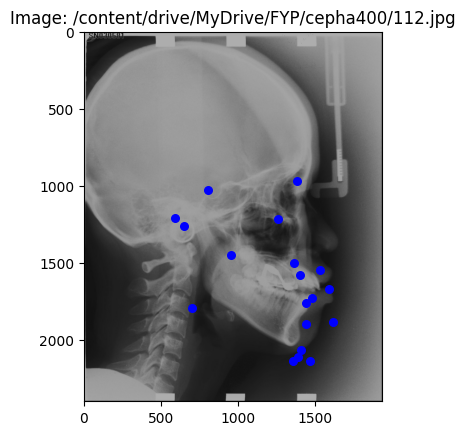

In [ ]:
model = YOLO("runs/detect/train15/weights/best.pt")

# Perform inference on a sample image
sample_image_path="/content/drive/MyDrive/FYP/cepha400/112.jpg"

from google.colab.patches import cv2_imshow
# Visualize the results
plot_image_with_landmarks(sample_image_path, landmarks, image_dir)

In [ ]:
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2

# Load your trained model
model = YOLO("runs/detect/train15/weights/best.pt")
image_dir = "/content/drive/MyDrive/FYP/cepha400"
results_list = []

for index, row in val_df.iterrows():
    image_path = row['image_path']
    img = cv2.imread(os.path.join(image_dir, image_path))
    if img is None:
        print(f"Warning: Image not found: {os.path.join(image_dir, image_path)}")
        continue

    results = model(img)

    for result in results:
        boxes = result.boxes
        for i, box in enumerate(boxes):
            xyxy = box.xyxy[0]
            cls = int(box.cls[0])

            x1, y1, x2, y2 = map(int, xyxy)
            pred_x = (x1 + x2) / 2
            pred_y = (y1 + y2) / 2

            true_x = row[f'{cls+1}_x']
            true_y = row[f'{cls+1}_y']

            dx = pred_x - true_x
            dy = pred_y - true_y
            radial_error = np.sqrt(dx**2 + dy**2)

            results_list.append([image_path, cls+1, pred_x, pred_y, true_x, true_y, dx, dy, radial_error])

results_df = pd.DataFrame(results_list, columns=['image_path', 'landmark', 'pred_x', 'pred_y', 'true_x', 'true_y', 'dx', 'dy', 'radial_error'])

mean_dx = results_df['dx'].mean()
mean_dy = results_df['dy'].mean()
mean_radial_error = results_df['radial_error'].mean()

print(f"Mean dx: {mean_dx}")
print(f"Mean dy: {mean_dy}")
print(f"Mean radial error: {mean_radial_error}")

results_df.to_csv("landmark_errors.csv", index=False)


0: 640x544 (no detections), 214.2ms
Speed: 10.2ms preprocess, 214.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 198.0ms
Speed: 6.4ms preprocess, 198.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 212.5ms
Speed: 7.3ms preprocess, 212.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 329.0ms
Speed: 12.8ms preprocess, 329.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 330.6ms
Speed: 9.7ms preprocess, 330.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 336.5ms
Speed: 6.7ms preprocess, 336.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 221.7ms
Speed: 6.8ms preprocess, 221.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 202.6ms
Speed: 6.0ms pre

In [ ]:


def calculate_mre(model, image_dir, ground_truth_csv):
    """Calculates the Mean Radial Error (MRE) for landmark detection."""
    model = YOLO(model)
    ground_truth_df = pd.read_csv(ground_truth_csv)
    total_radial_error = 0
    total_landmarks = 0

    for index, row in ground_truth_df.iterrows():
        image_path = row['image_path']
        img = cv2.imread(os.path.join(image_dir, image_path))
        if img is None:
            print(f"Warning: Image not found: {os.path.join(image_dir, image_path)}")
            continue
        results = model(img)
        for result in results:
            boxes = result.boxes
            for i, box in enumerate(boxes):
                xyxy = box.xyxy[0]
                cls = int(box.cls[0])

                x1, y1, x2, y2 = map(int, xyxy)
                pred_x = (x1 + x2) / 2
                pred_y = (y1 + y2) / 2

                true_x = row[f'{cls+1}_x']
                true_y = row[f'{cls+1}_y']

                dx = pred_x - true_x
                dy = pred_y - true_y
                radial_error = np.sqrt(dx**2 + dy**2)

                total_radial_error += radial_error
                total_landmarks += 1

    if total_landmarks > 0:
        mre = total_radial_error / total_landmarks
        return mre
    else:
        return None

# Example usage:
model_path = "runs/detect/train15/weights/best.pt"
ground_truth_csv = "/content/drive/MyDrive/FYP/combined_cepha.csv"

mre = calculate_mre(model_path, image_dir, ground_truth_csv)

if mre is not None:
    print(f"Mean Radial Error (MRE): {mre:.2f} pixels")
else:
    print("No landmarks detected or errors in data.")


0: 640x544 (no detections), 221.0ms
Speed: 8.0ms preprocess, 221.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 209.2ms
Speed: 6.7ms preprocess, 209.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 205.7ms
Speed: 7.3ms preprocess, 205.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 212.0ms
Speed: 5.7ms preprocess, 212.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 219.0ms
Speed: 7.0ms preprocess, 219.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 203.8ms
Speed: 7.6ms preprocess, 203.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 212.9ms
Speed: 6.4ms preprocess, 212.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 213.5ms
Speed: 6.6ms prepr